In [1]:
def group_results(experiments, outcomes, group_by, grouping_specifiers,
                  grouping_labels):
    groups = {}
    if group_by != 'index':
        column_to_group_by = experiments.loc[:, group_by]

    for label, specifier in zip(grouping_labels, grouping_specifiers):
        if isinstance(specifier, tuple):
            # the grouping is a continuous uncertainty
            lower_limit, upper_limit = specifier

            # check whether it is the last grouping specifier
            if grouping_specifiers.index(specifier) ==\
                    len(grouping_specifiers) - 1:
                # last case

                logical = (column_to_group_by >= lower_limit) &\
                    (column_to_group_by <= upper_limit)
            else:
                logical = (column_to_group_by >= lower_limit) &\
                    (column_to_group_by < upper_limit)
        elif group_by == 'index':
            # the grouping is based on indices
            logical = specifier
        else:
            # the grouping is an integer or categorical uncertainty
            logical = column_to_group_by == specifier

        group_outcomes = {}
        for key, value in outcomes.items():
            value = value[logical]
            group_outcomes[key] = value
        groups[label] = (experiments.loc[logical, :], group_outcomes)

    return groups


# Multi-Objective Dam Problem (Random Initial)

In [2]:
%%time
import sys, random
sys.path.append("../")
import numpy as np
from models.ema_dam_uncertain1 import dam_uncertain_problem1
from utils.ea.create_models import create_dam_robust_training
from EMAWorkbench import MultiprocessingEvaluator, ema_logging

random_seed = 3186775264
random_seed = random_seed
random.seed(random_seed)
np.random.seed(random_seed)
dam_soft_model, convergence_metrics = create_dam_robust_training(problem=dam_uncertain_problem1, random_seed=random_seed)
    
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 200
n_policies = 20

with MultiprocessingEvaluator(dam_soft_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 200 scenarios * 20 policies * 1 model(s) = 4000 experiments
/Users/zppei/Documents/PhD-Project/code/Evolutionary/analyses/../EMAWorkbench/em_framework/callbacks.py:191: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = pd.Series(dtype=dtype)
/Users/zppei/Documents/PhD-Project/code/Evolutionary/analyses/../EMAWorkbench/em_framework/callbacks.py:191: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = pd.Series(dtype=dtype)
/Users/zppei/Documents/PhD-Project

CPU times: user 5.67 s, sys: 503 ms, total: 6.18 s
Wall time: 9.9 s


In [3]:
results

(          s_init     0    1   10   11   12   13   14   15   16  ...   93   94  \
 0     164.764069   3.0  8.0  8.0  1.0  2.0  5.0  1.0  8.0  2.0  ...  3.0  7.0   
 1     163.329084   3.0  8.0  8.0  1.0  2.0  5.0  1.0  8.0  2.0  ...  3.0  7.0   
 2     132.561850   3.0  8.0  8.0  1.0  2.0  5.0  1.0  8.0  2.0  ...  3.0  7.0   
 3     134.602561   3.0  8.0  8.0  1.0  2.0  5.0  1.0  8.0  2.0  ...  3.0  7.0   
 4     184.301308   3.0  8.0  8.0  1.0  2.0  5.0  1.0  8.0  2.0  ...  3.0  7.0   
 ...          ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
 3995  169.201454  10.0  5.0  9.0  5.0  8.0  7.0  4.0  6.0  7.0  ...  6.0  7.0   
 3996  199.992271  10.0  5.0  9.0  5.0  8.0  7.0  4.0  6.0  7.0  ...  6.0  7.0   
 3997  179.608782  10.0  5.0  9.0  5.0  8.0  7.0  4.0  6.0  7.0  ...  6.0  7.0   
 3998  198.304384  10.0  5.0  9.0  5.0  8.0  7.0  4.0  6.0  7.0  ...  6.0  7.0   
 3999  166.514866  10.0  5.0  9.0  5.0  8.0  7.0  4.0  6.0  7.0  ...  6.0  7.0   
 
         95   

Text(0.5, 0, 'Number of scenarios')

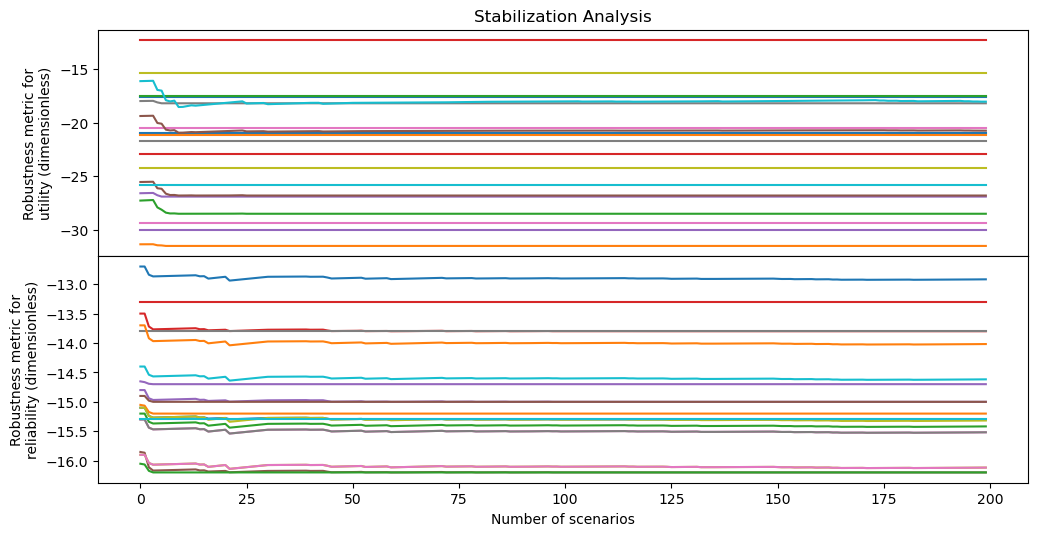

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# from EMAWorkbench.analysis.plotting_util import group_results
from utils.robust_scores import percentile_10, mean_variance, avg, obj_func

size = 200
experiments, outcomes = results
policies = set(experiments['policy']) 
results_df = group_results(experiments, outcomes, group_by='policy', grouping_specifiers=policies, grouping_labels=policies)
r_utility = np.zeros((len(policies), size))
r_reliability = np.zeros((len(policies), size))
r_utility_1 = np.zeros((len(policies), size))
r_reliability_1 = np.zeros((len(policies), size))
r_utility_2 = np.zeros((len(policies), size))
r_reliability_2 = np.zeros((len(policies), size))
i = -1 

for pathway, group_res in results_df.items(): 
    i+=1 
    ge, go = group_res 
    n = ge.shape[0]

    for j in range(n): 
        temp_outcomes = {}
        for key, value in go.items():
            temp_value = value[0:(j+1),]
            temp_outcomes[key] = temp_value
        r_1, r_2 = percentile_10(temp_outcomes)
        r_11, r_21 = mean_variance(temp_outcomes)
        r_12, r_22 = avg(temp_outcomes)
        r_utility[i, j] = r_1
        r_reliability[i, j] = r_2
        r_utility_1[i, j] = r_11
        r_reliability_1[i, j] = r_21
        r_utility_2[i, j] = r_12
        r_reliability_2[i, j] = r_22

robustness = {"utility": r_utility, "reliability":r_reliability}
fig = plt.figure(figsize=(12,6), dpi=100)
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')
ax1.plot(robustness['utility'].T)
ax2.plot(robustness['reliability'].T)
ax1.set_title("Stabilization Analysis")
ax1.set(ylabel='Robustness metric for\nutility (dimensionless)')
ax2.set(ylabel='Robustness metric for\nreliability (dimensionless)')
ax2.set_xlabel("Number of scenarios")

Text(0.5, 0, 'Number of scenarios')

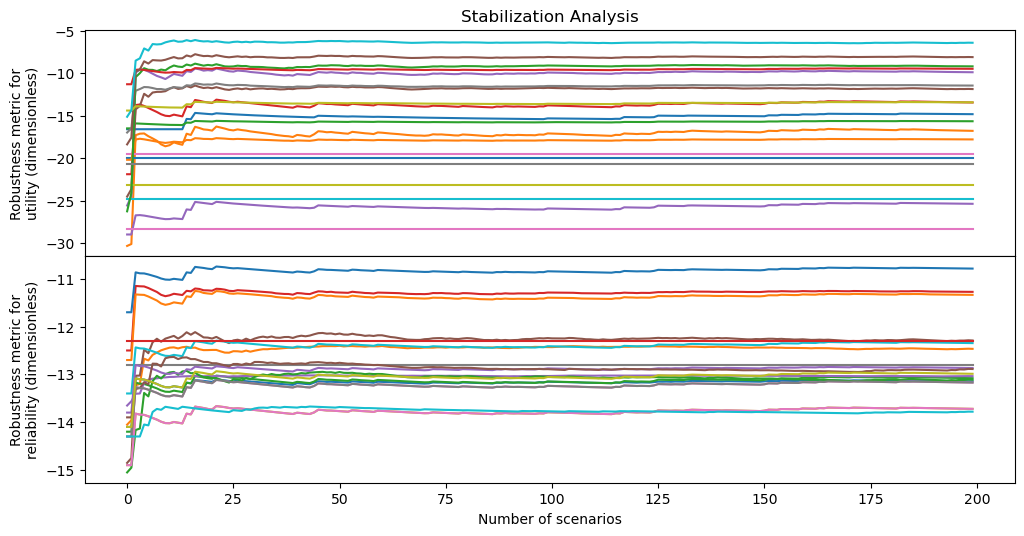

In [5]:
robustness = {"utility": r_utility_1, "reliability":r_reliability_1}
fig = plt.figure(figsize=(12,6), dpi=100)
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')
ax1.plot(robustness['utility'].T)
ax2.plot(robustness['reliability'].T)
ax1.set_title("Stabilization Analysis")
ax1.set(ylabel='Robustness metric for\nutility (dimensionless)')
ax2.set(ylabel='Robustness metric for\nreliability (dimensionless)')
ax2.set_xlabel("Number of scenarios")

Text(0.5, 0, 'Number of scenarios')

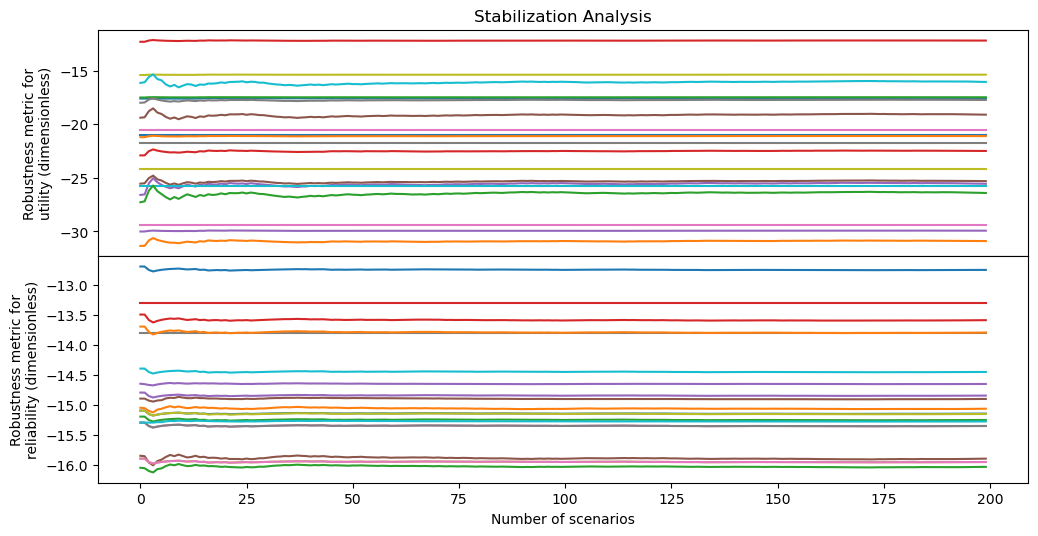

In [6]:
robustness = {"utility": r_utility_2, "reliability":r_reliability_2}
fig = plt.figure(figsize=(12,6), dpi=100)
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')
ax1.plot(robustness['utility'].T)
ax2.plot(robustness['reliability'].T)
ax1.set_title("Stabilization Analysis")
ax1.set(ylabel='Robustness metric for\nutility (dimensionless)')
ax2.set(ylabel='Robustness metric for\nreliability (dimensionless)')
ax2.set_xlabel("Number of scenarios")

# Multi-Objective Dam Problem (Deep)

In [7]:
%%time
import sys, random
sys.path.append("../")
import numpy as np
from models.ema_dam_uncertain1 import dam_uncertain_problem1
from utils.ea.create_models import create_dam_deep_training
from EMAWorkbench import MultiprocessingEvaluator, ema_logging

random_seed = 3186775264
random_seed = random_seed
random.seed(random_seed)
np.random.seed(random_seed)
dam_soft_model, convergence_metrics = create_dam_deep_training(problem=dam_uncertain_problem1, random_seed=random_seed)
    
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 200
n_policies = 20

with MultiprocessingEvaluator(dam_soft_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 200 scenarios * 20 policies * 1 model(s) = 4000 experiments
/Users/zppei/Documents/PhD-Project/code/Evolutionary/analyses/../EMAWorkbench/em_framework/callbacks.py:191: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = pd.Series(dtype=dtype)
/Users/zppei/Documents/PhD-Project/code/Evolutionary/analyses/../EMAWorkbench/em_framework/callbacks.py:191: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = pd.Series(dtype=dtype)
/Users/zppei/Documents/PhD-Project

CPU times: user 4.38 s, sys: 343 ms, total: 4.73 s
Wall time: 8.08 s


In [8]:
results

(          s_init     0    1   10   11   12   13   14   15   16  ...   93   94  \
 0     164.764069   3.0  8.0  8.0  1.0  2.0  5.0  1.0  8.0  2.0  ...  3.0  7.0   
 1     163.329084   3.0  8.0  8.0  1.0  2.0  5.0  1.0  8.0  2.0  ...  3.0  7.0   
 2     132.561850   3.0  8.0  8.0  1.0  2.0  5.0  1.0  8.0  2.0  ...  3.0  7.0   
 3     134.602561   3.0  8.0  8.0  1.0  2.0  5.0  1.0  8.0  2.0  ...  3.0  7.0   
 4     184.301308   3.0  8.0  8.0  1.0  2.0  5.0  1.0  8.0  2.0  ...  3.0  7.0   
 ...          ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
 3995  169.201454  10.0  5.0  9.0  5.0  8.0  7.0  4.0  6.0  7.0  ...  6.0  7.0   
 3996  199.992271  10.0  5.0  9.0  5.0  8.0  7.0  4.0  6.0  7.0  ...  6.0  7.0   
 3997  179.608782  10.0  5.0  9.0  5.0  8.0  7.0  4.0  6.0  7.0  ...  6.0  7.0   
 3998  198.304384  10.0  5.0  9.0  5.0  8.0  7.0  4.0  6.0  7.0  ...  6.0  7.0   
 3999  166.514866  10.0  5.0  9.0  5.0  8.0  7.0  4.0  6.0  7.0  ...  6.0  7.0   
 
         95   

Text(0.5, 0, 'Number of scenarios')

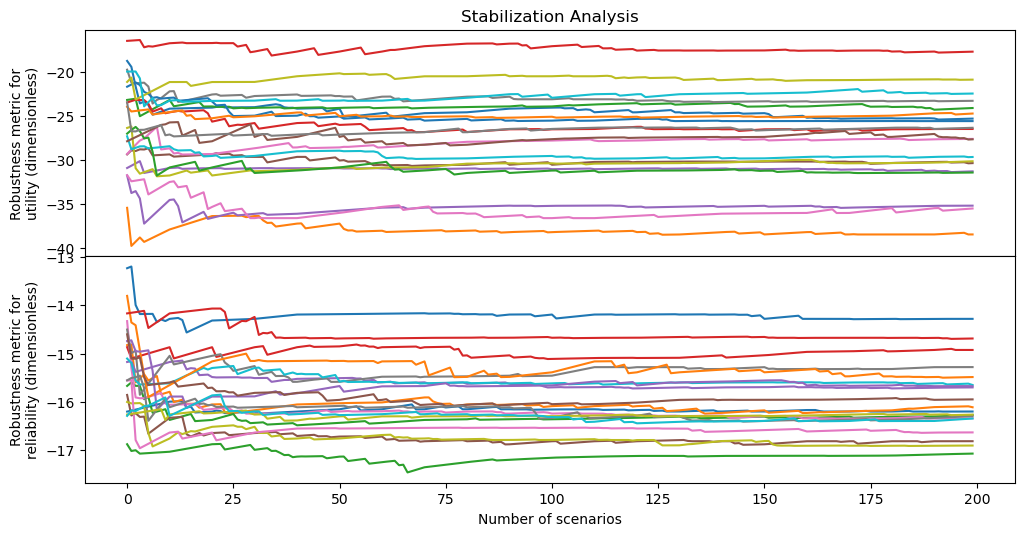

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# from EMAWorkbench.analysis.plotting_util import group_results
from utils.robust_scores import percentile_10, mean_variance, avg, obj_func

size = 200
experiments, outcomes = results
policies = set(experiments['policy']) 
results_df = group_results(experiments, outcomes, group_by='policy', grouping_specifiers=policies, grouping_labels=policies)
r_utility = np.zeros((len(policies), size))
r_reliability = np.zeros((len(policies), size))
r_utility_1 = np.zeros((len(policies), size))
r_reliability_1 = np.zeros((len(policies), size))
r_utility_2 = np.zeros((len(policies), size))
r_reliability_2 = np.zeros((len(policies), size))
i = -1 

for pathway, group_res in results_df.items(): 
    i+=1 
    ge, go = group_res 
    n = ge.shape[0]

    for j in range(n): 
        temp_outcomes = {}
        for key, value in go.items():
            temp_value = value[0:(j+1),]
            temp_outcomes[key] = temp_value
        r_1, r_2 = percentile_10(temp_outcomes)
        r_11, r_21 = mean_variance(temp_outcomes)
        r_12, r_22 = avg(temp_outcomes)
        r_utility[i, j] = r_1
        r_reliability[i, j] = r_2
        r_utility_1[i, j] = r_11
        r_reliability_1[i, j] = r_21
        r_utility_2[i, j] = r_12
        r_reliability_2[i, j] = r_22

robustness = {"utility": r_utility, "reliability":r_reliability}
fig = plt.figure(figsize=(12,6), dpi=100)
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')
ax1.plot(robustness['utility'].T)
ax2.plot(robustness['reliability'].T)
ax1.set_title("Stabilization Analysis")
ax1.set(ylabel='Robustness metric for\nutility (dimensionless)')
ax2.set(ylabel='Robustness metric for\nreliability (dimensionless)')
ax2.set_xlabel("Number of scenarios")

Text(0.5, 0, 'Number of scenarios')

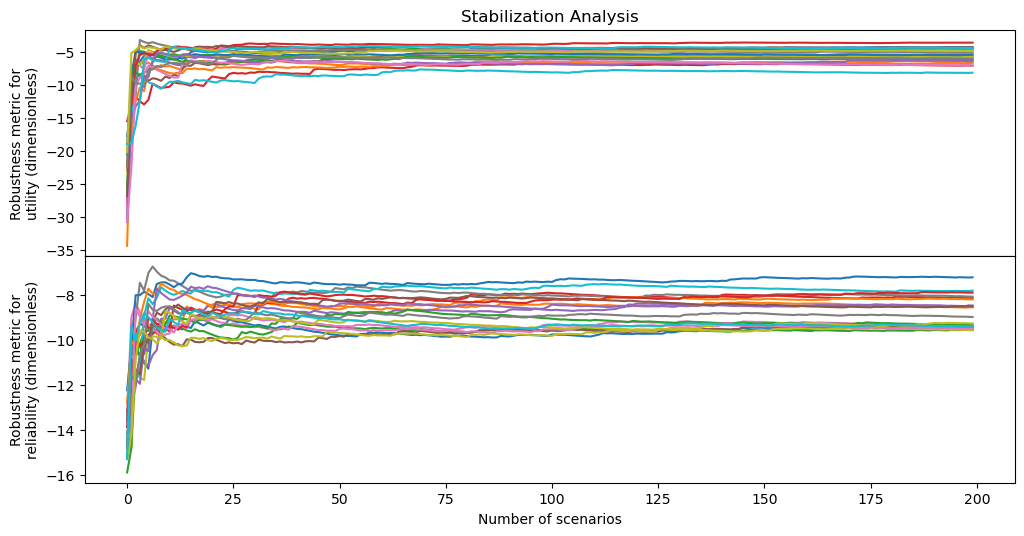

In [10]:
robustness = {"utility": r_utility_1, "reliability":r_reliability_1}
fig = plt.figure(figsize=(12,6), dpi=100)
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')
ax1.plot(robustness['utility'].T)
ax2.plot(robustness['reliability'].T)
ax1.set_title("Stabilization Analysis")
ax1.set(ylabel='Robustness metric for\nutility (dimensionless)')
ax2.set(ylabel='Robustness metric for\nreliability (dimensionless)')
ax2.set_xlabel("Number of scenarios")

Text(0.5, 0, 'Number of scenarios')

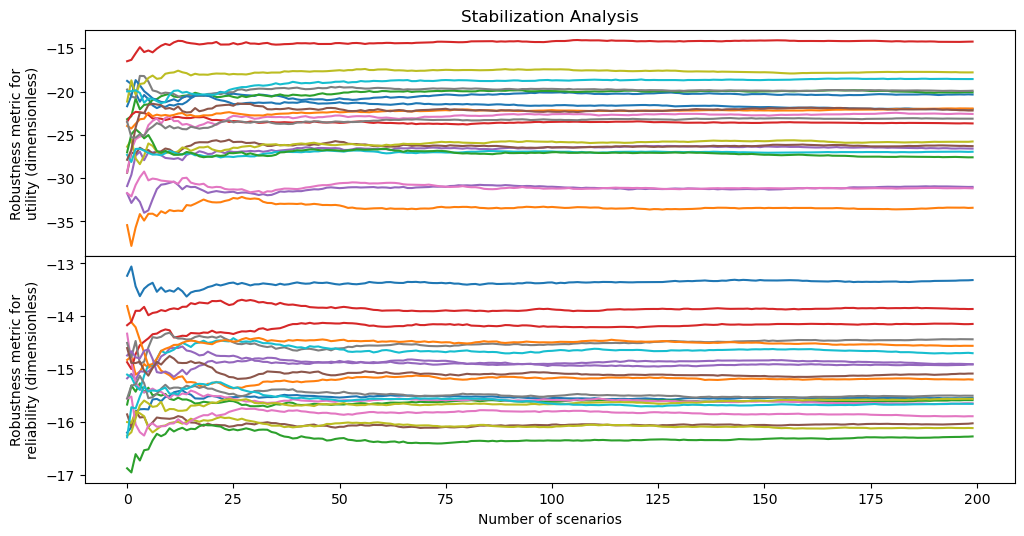

In [11]:
robustness = {"utility": r_utility_2, "reliability":r_reliability_2}
fig = plt.figure(figsize=(12,6), dpi=100)
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')
ax1.plot(robustness['utility'].T)
ax2.plot(robustness['reliability'].T)
ax1.set_title("Stabilization Analysis")
ax1.set(ylabel='Robustness metric for\nutility (dimensionless)')
ax2.set(ylabel='Robustness metric for\nreliability (dimensionless)')
ax2.set_xlabel("Number of scenarios")

# 3-Objective Dam Problem

In [2]:
%%time
import sys, random
sys.path.append("../")
import numpy as np
from models.ema_dam_uncertain import dam_uncertain_problem
from utils.ea.create_models import create_dam3_deep_training
from EMAWorkbench import MultiprocessingEvaluator, ema_logging

random_seed = 3186775264
random_seed = random_seed
random.seed(random_seed)
np.random.seed(random_seed)
dam_soft_model, convergence_metrics = create_dam3_deep_training(problem=dam_uncertain_problem, random_seed=random_seed)
    
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 200
n_policies = 20

with MultiprocessingEvaluator(dam_soft_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 200 scenarios * 20 policies * 1 model(s) = 4000 experiments
/Users/zppei/Documents/PhD-Project/code/Evolutionary/analyses/../EMAWorkbench/em_framework/callbacks.py:191: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = pd.Series(dtype=dtype)
/Users/zppei/Documents/PhD-Project/code/Evolutionary/analyses/../EMAWorkbench/em_framework/callbacks.py:191: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = pd.Series(dtype=dtype)
/Users/zppei/Documents/PhD-Project

CPU times: user 6.45 s, sys: 458 ms, total: 6.91 s
Wall time: 11.5 s


Text(0.5, 0, 'Number of scenarios')

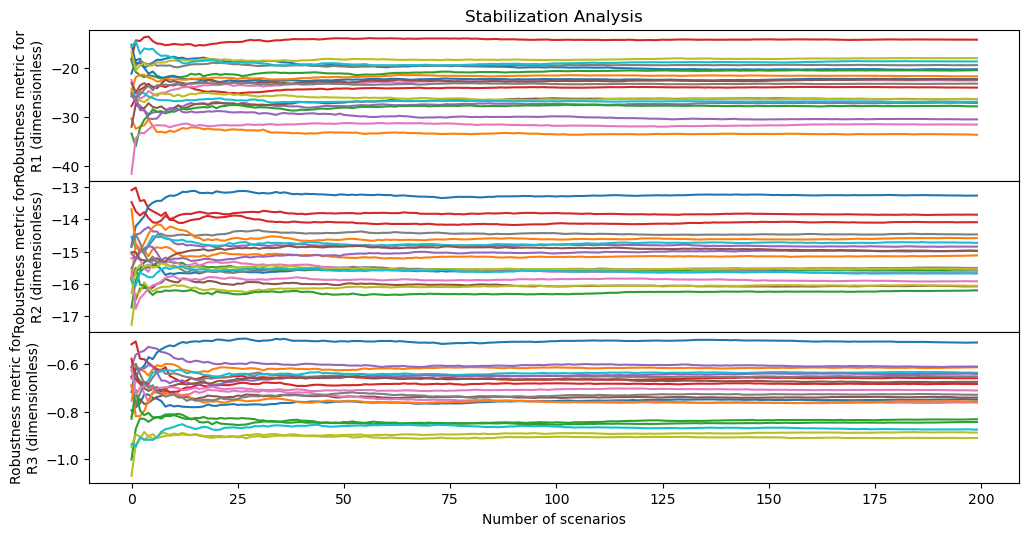

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# from EMAWorkbench.analysis.plotting_util import group_results
from utils.robust_scores import obj3_avg

size = 200
experiments, outcomes = results
policies = set(experiments['policy']) 
results_df = group_results(experiments, outcomes, group_by='policy', grouping_specifiers=policies, grouping_labels=policies)
R1 = np.zeros((len(policies), size))
R2 = np.zeros((len(policies), size))
R3 = np.zeros((len(policies), size))
i = -1 

for pathway, group_res in results_df.items(): 
    i+=1 
    ge, go = group_res 
    n = ge.shape[0]

    for j in range(n): 
        temp_outcomes = {}
        for key, value in go.items():
            temp_value = value[0:(j+1),]
            temp_outcomes[key] = temp_value
        r_1, r_2, r_3 = obj3_avg(temp_outcomes)
        R1[i, j] = r_1
        R2[i, j] = r_2
        R3[i, j] = r_3

robustness = {"obj1": R1, "obj2":R2, "obj3":R3}
fig = plt.figure(figsize=(12,6), dpi=100)
gs = fig.add_gridspec(3, 1, hspace=0, wspace=0)
ax1, ax2, ax3 = gs.subplots(sharex='col', sharey='row')
ax1.plot(robustness['obj1'].T)
ax2.plot(robustness['obj2'].T)
ax3.plot(robustness['obj3'].T)
ax1.set_title("Stabilization Analysis")
ax1.set(ylabel='Robustness metric for\nR1 (dimensionless)')
ax2.set(ylabel='Robustness metric for\nR2 (dimensionless)')
ax3.set(ylabel='Robustness metric for\nR3 (dimensionless)')
ax3.set_xlabel("Number of scenarios")

# Multi-Objective Lake Problem

In [2]:
%%time
import sys, random
sys.path.append("../")
import numpy as np
from models.ema_lake4_uncertain import lake4_uncertain_problem
from utils.ea.create_models import create_lake4_deep_training
from EMAWorkbench import MultiprocessingEvaluator, ema_logging

random_seed = 3186775264
random_seed = random_seed
random.seed(random_seed)
np.random.seed(random_seed)
lake_soft_model, convergence_metrics = create_lake4_deep_training(problem=lake4_uncertain_problem, random_seed=random_seed)
    
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 200
n_policies = 20

with MultiprocessingEvaluator(lake_soft_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 200 scenarios * 20 policies * 1 model(s) = 4000 experiments
/Users/zppei/Documents/PhD-Project/code/Evolutionary/analyses/../EMAWorkbench/em_framework/callbacks.py:191: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = pd.Series(dtype=dtype)
/Users/zppei/Documents/PhD-Project/code/Evolutionary/analyses/../EMAWorkbench/em_framework/callbacks.py:191: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = pd.Series(dtype=dtype)
/Users/zppei/Documents/PhD-Project

CPU times: user 5.64 s, sys: 732 ms, total: 6.38 s
Wall time: 16.7 s


In [3]:
results

(             b     delta      mean         q     stdev     0    1   10   11  \
 0     0.295843  0.988576  0.039556  3.566131  0.001676  10.0  3.0  4.0  0.0   
 1     0.289565  0.952797  0.019444  4.434291  0.003709  10.0  3.0  4.0  0.0   
 2     0.154958  0.952057  0.031711  2.083248  0.003321  10.0  3.0  4.0  0.0   
 3     0.163886  0.936227  0.026152  3.307938  0.002362  10.0  3.0  4.0  0.0   
 4     0.381318  0.945117  0.032243  2.608055  0.001797  10.0  3.0  4.0  0.0   
 ...        ...       ...       ...       ...       ...   ...  ...  ...  ...   
 3995  0.315256  0.966248  0.036276  3.488337  0.001707   2.0  1.0  2.0  1.0   
 3996  0.449966  0.964300  0.041853  4.458470  0.001343   2.0  1.0  2.0  1.0   
 3997  0.360788  0.984139  0.010003  4.077031  0.001817   2.0  1.0  2.0  1.0   
 3998  0.442582  0.989933  0.043030  2.889002  0.003831   2.0  1.0  2.0  1.0   
 3999  0.303503  0.967568  0.027829  2.433958  0.004535   2.0  1.0  2.0  1.0   
 
        12  ...   93    94   95   96  

## Stabilization analysis results

Text(0.5, 0, 'Number of scenarios')

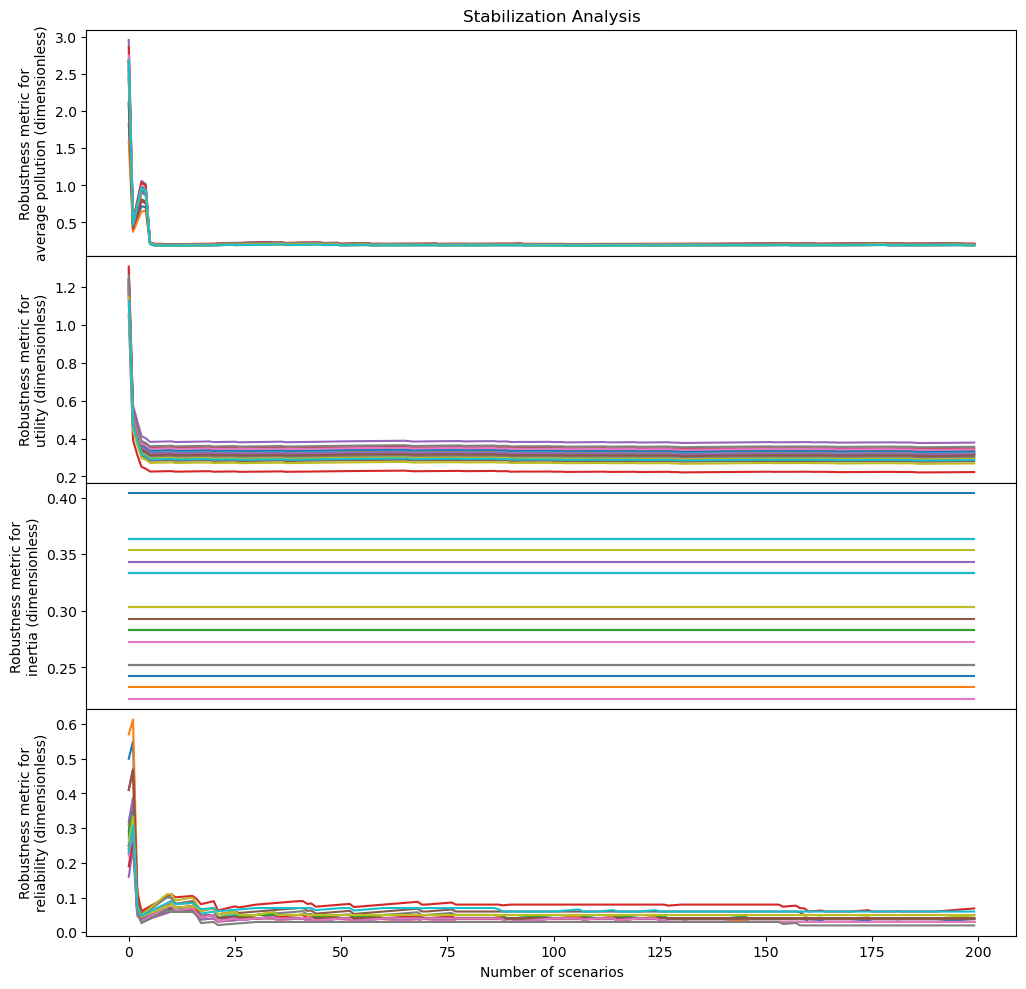

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# from EMAWorkbench.analysis.plotting_util import group_results
from utils.robust_scores import lake4_percentile_10, lake4_avg

size = 200
experiments, outcomes = results
policies = set(experiments['policy']) 
results_df = group_results(experiments, outcomes, group_by='policy', grouping_specifiers=policies, grouping_labels=policies)
r_avg_pollution = np.zeros((len(policies), size))
r_utility = np.zeros((len(policies), size))
r_inertia = np.zeros((len(policies), size))
r_reliability = np.zeros((len(policies), size))
r_avg_pollution_1 = np.zeros((len(policies), size))
r_utility_1 = np.zeros((len(policies), size))
r_inertia_1 = np.zeros((len(policies), size))
r_reliability_1 = np.zeros((len(policies), size))
i = -1 

for pathway, group_res in results_df.items(): 
    i+=1 
    ge, go = group_res 
    n = ge.shape[0]

    for j in range(n): 
        temp_outcomes = {}
        for key, value in go.items():
            temp_value = value[0:(j+1),]
            temp_outcomes[key] = temp_value
        r_1, r_2, r_3, r_4 = lake4_percentile_10(temp_outcomes)
        r_11, r_12, r_13, r_14 = lake4_avg(temp_outcomes)
        r_avg_pollution[i, j] = r_1
        r_utility[i, j] = r_2
        r_inertia[i, j] = r_3
        r_reliability[i, j] = r_4
        r_avg_pollution_1[i, j] = r_11
        r_utility_1[i, j] = r_12
        r_inertia_1[i, j] = r_13
        r_reliability_1[i, j] = r_14

robustness = {"avg_pollution":r_avg_pollution, "utility":r_utility, "inertia":r_inertia, "reliability":r_reliability}
fig = plt.figure(figsize=(12,12), dpi=100)
gs = fig.add_gridspec(4, 1, hspace=0, wspace=0)
ax1, ax2, ax3, ax4 = gs.subplots(sharex='col', sharey='row')
ax1.plot(robustness['avg_pollution'].T)
ax2.plot(robustness['utility'].T)
ax3.plot(robustness['inertia'].T)
ax4.plot(robustness['reliability'].T)
ax1.set_title("Stabilization Analysis")
ax1.set(ylabel='Robustness metric for\naverage pollution (dimensionless)')
ax2.set(ylabel='Robustness metric for\nutility (dimensionless)')
ax3.set(ylabel='Robustness metric for\ninertia (dimensionless)')
ax4.set(ylabel='Robustness metric for\nreliability (dimensionless)')
ax4.set_xlabel("Number of scenarios")

Text(0.5, 0, 'Number of scenarios')

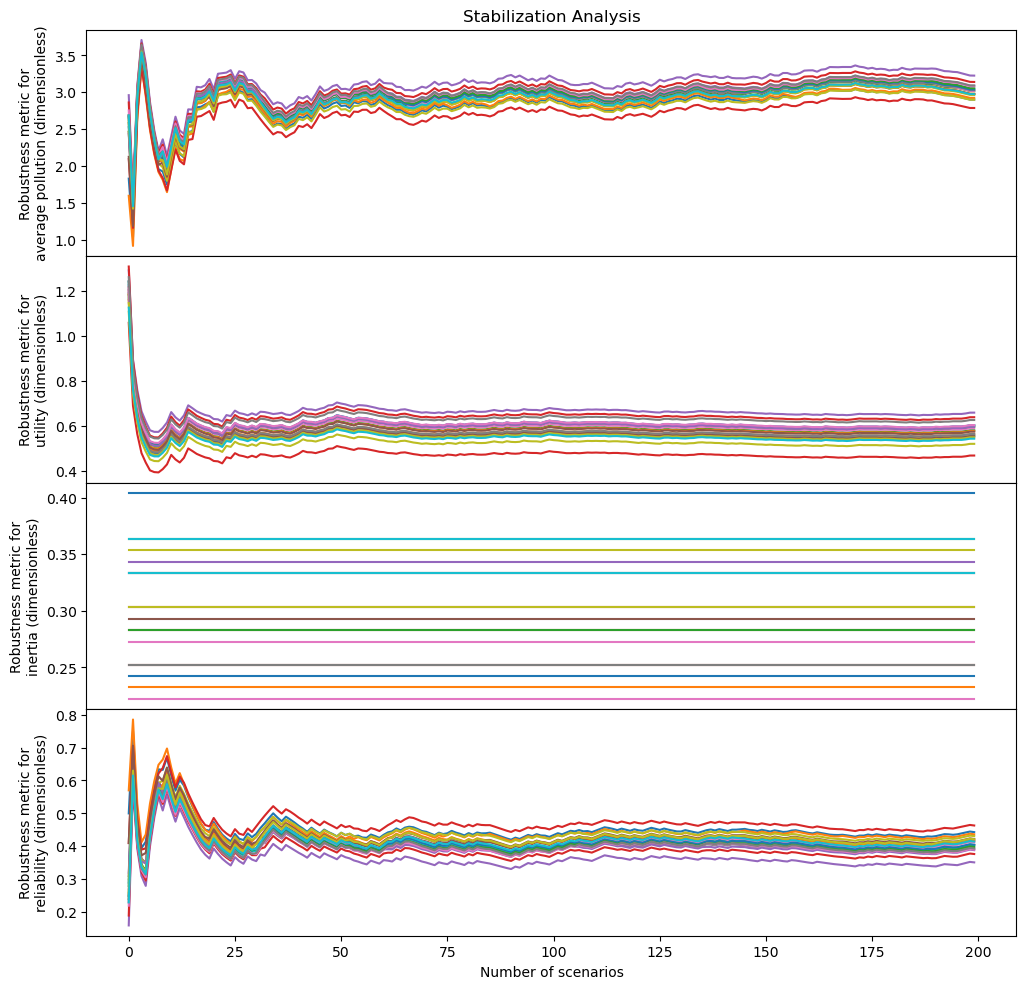

In [5]:
robustness = {"avg_pollution":r_avg_pollution_1, "utility":r_utility_1, "inertia":r_inertia_1, "reliability":r_reliability_1}
fig = plt.figure(figsize=(12,12), dpi=100)
gs = fig.add_gridspec(4, 1, hspace=0, wspace=0)
ax1, ax2, ax3, ax4 = gs.subplots(sharex='col', sharey='row')
ax1.plot(robustness['avg_pollution'].T)
ax2.plot(robustness['utility'].T)
ax3.plot(robustness['inertia'].T)
ax4.plot(robustness['reliability'].T)
ax1.set_title("Stabilization Analysis")
ax1.set(ylabel='Robustness metric for\naverage pollution (dimensionless)')
ax2.set(ylabel='Robustness metric for\nutility (dimensionless)')
ax3.set(ylabel='Robustness metric for\ninertia (dimensionless)')
ax4.set(ylabel='Robustness metric for\nreliability (dimensionless)')
ax4.set_xlabel("Number of scenarios")